# LAB 5 : Convolutional Neural Networks  

Name : Girish Kumar Gupta

Roll Number : 211022002

Referrence Material : 

  MNIST Digit Dataset : http://yann.lecun.com/exdb/mnist/

  CNN : https://towardsdatascience.com/a-guide-to-convolutional-neural-networks-from-scratch-f1e3bfc3e2de

#**Problem 1** : Demonstrate the working principle of convolution neural network (CNN)

Observation to be demonstrated:
1. Use suitable data to demonstrate the same (MNIST digit data can be used).
2. Demonstrate the translation invariant property of pooling layer (can choose two
image, from which one is translated and show the output of pooling layer is near
to identical for both the images ).
3. Demonstrate how backpropagation works with max pooling layer.

the same.

**Note: Take only two class and a small network, and write you own code to demonstrate the same.**

##Write down the Objectives, Hypothesis and Experimental description for the above problem


#### Objective:  
To implement Convolutional Neural Network from scratch.


## Programming : 
  Please write a program to demonstrate the same

In [13]:
## Write your code here
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import numpy as np
from sklearn.utils import shuffle
from keras.datasets import mnist

def get_MNIST(req_class,sze):
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  img_rows, img_cols = sze, sze

  # req_class=[2, 3]
  train_com = []
  train_lab = []
  test_com = []
  test_lab = []

  for i in req_class:
    digit=i
    cl1 = i
    ###########################################################################
    i, = np.where(y_train == cl1)
    cl1_train = x_train[i,:,:] # pull out the data corresponds to class1
    cl1_train_label = y_train[i] # pull out the data labels corresponds to class1
    #Resizing
    [number_of_images,_,_]=np.shape(cl1_train)
    cl1_train = cl1_train.astype('float32')
    cl1_train /= 255
    cl1_train[cl1_train>=0.5] = 1
    cl1_train[cl1_train<0.5] = 0
    train_com.append(cl1_train[0:250]) # Merge the data
    train_lab.append(cl1_train_label[0:250]) # Merge the labels
    ############################################################################
    i, = np.where(y_test == cl1)
    cl1_test = x_test[i,:,:] # pull out the data corresponds to class1
    cl1_test_label = y_test[i] # pull out the data labels corresponds to class1
    #Resizing
    [number_of_images,_,_]=np.shape(cl1_test)
    cl1_test = cl1_test.astype('float32')
    cl1_test /= 255
    cl1_test[cl1_test>=0.5] = 1
    cl1_test[cl1_test<0.5] = 0
    test_com.append(cl1_test[0:125]) # Merge the data
    test_lab.append(cl1_test_label[0:125]) # Merge the labels
  #############################################################################%
  train_df_lab = np.concatenate(train_lab, axis = 0)
  train_df_data = np.concatenate(train_com, axis = 0)
  [train_sff,train_labs] = shuffle(train_df_data, train_df_lab) # Shuffle the data and label (to properly train the network)
  test_df_lab = np.concatenate(test_lab, axis = 0)
  test_df_data = np.concatenate(test_com, axis = 0)
  [test_sff,test_labs] = shuffle(test_df_data, test_df_lab) # Shuffle the data and label (to properly train the network)
  return(train_sff,train_labs,test_sff,test_labs)

In [14]:
dataset=[1,2]
sze=28 #size of the MNIST data
train_images, train_labels, test_images, test_labels = get_MNIST(dataset,sze)

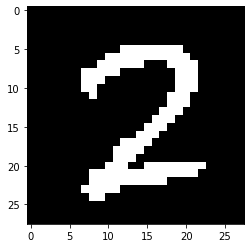

In [15]:
X = train_images[0,:,:]
X = np.reshape(X,(28,28))
plt.figure()
plt.imshow(X, cmap='gray')
# print(X)

In [16]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(500, 28, 28)
(500,)
(250, 28, 28)
(250,)


## Theory
### Convolutional Neural Network



*   CNNs are used to perform image classification task. Images are generally $N$x$N$ large (e.g., $28$x$28$ and this is equivalent to 784 which is size of feature vector) and will require millions of parameters when classified using fully connected FFNN.
*   CNN reduces the size on every step and hence require very less parameters compared to FFNN.
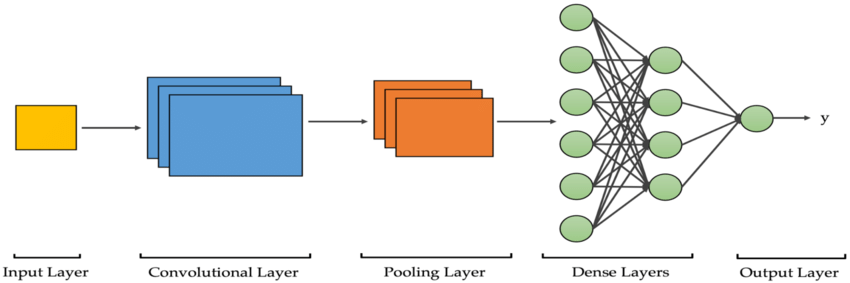



*   Here for MNIST dataset width(W) and height(H) of dataset is $28$.
*   Kernel of $3*3$ is used for convolution operation (Multiply -> Add -> Accumulate).

$ S_{ij}=(I*K)_{ij}=∑_{a=0}^{m-1}∑_{b=0}^{n-1}I_{i-a,j-b}K_{a,b}$
*   The size of convolution layer will reduce to where is width of convolution output, is width of input image and F is size of kernel.
*   For the max pooling layer stride (S) of 2 is used. Output size will reduce by half. In this layer maximum value within the window size of 2*2 is chosen and stored.
*   The output of the pooling layer is flattened and passed as an input to fully connected FFNN.
*   The output of FFNN classify accordingly.
*   The activation function of the output layer is taken to be softmax and loss function is entropy

###*Backpropogation:*
BP in FFNN:

*   Backpropagation is performed from right to left i.e. from output layer of FFNN to convolution layer.
*   Here the loss function is $L = -log(p_{e})$
*   We need the gradient w.r.t weights, baises input in the FFNN.
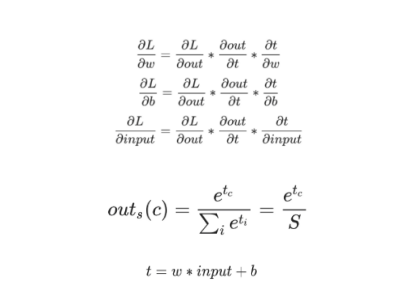

BP in maxpool layer:
*   In the maxpooling layer we just pick the maximum number within the window size. So, there are no weights and no need to learn the weights.
*   In the backpropagation we need to move from maxpooling layer size to convolution layer size. Therefore, we retain only the max values and keep all others as zero.
BP in convolution layer:
*  Output of convolution layer depends on the filter.






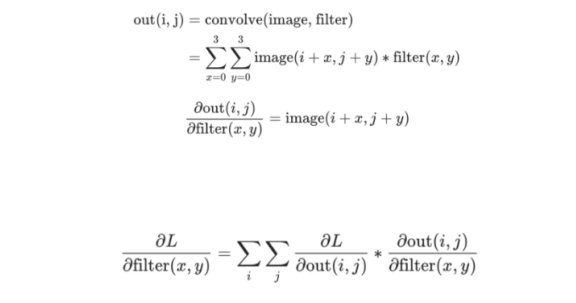

## Implementation

### *Convolution layer*

In [17]:
class Conv3x3:
  # A Convolution layer using 3x3 filters.
  def __init__(self, num_filters):
    self.num_filters = num_filters
    # filters is a 3d array with dimensions (num_filters, 3, 3)
    # We divide by 9 to reduce the variance of our initial values
    self.filters = np.random.randn(num_filters, 3, 3) / 9
  def iterate_regions(self, image):
    '''
    Generates all possible 3x3 image regions using valid padding.
    - image is a 2d numpy array.
    '''
    h, w = image.shape
    for i in range(h - 2):
      for j in range(w - 2):
        im_region = image[i:(i + 3), j:(j + 3)]
        yield im_region, i, j
  def forward(self, input):
    '''
    Performs a forward pass of the conv layer using the given input.
    Returns a 3d numpy array with dimensions (h, w, num_filters).
    - input is a 2d numpy array
    '''
    self.last_input = input
    h, w = input.shape
    output = np.zeros((h - 2, w - 2, self.num_filters))
    for im_region, i, j in self.iterate_regions(input):
      output[i, j] = np.sum(im_region * self.filters, axis=(1, 2))
    return output
  def backprop(self, d_L_d_out, learn_rate):
    '''
    Performs a backward pass of the conv layer.
    - d_L_d_out is the loss gradient for this layer's outputs.
    - learn_rate is a float.
    '''
    d_L_d_filters = np.zeros(self.filters.shape)
    for im_region, i, j in self.iterate_regions(self.last_input):
      for f in range(self.num_filters):
        d_L_d_filters[f] += d_L_d_out[i, j, f] * im_region
    # Update filters
    self.filters -= learn_rate * d_L_d_filters
    # We aren't returning anything here since we use Conv3x3 as the first layer in our CNN.
    # Otherwise, we'd need to return the loss gradient for this layer's inputs,just like every
    # other layer in our CNN.
    return None

### *Max Pooling*

In [18]:
class MaxPool2:
  # A Max Pooling layer using a pool size of 2.
  def iterate_regions(self, image):
    '''
    Generates non-overlapping 2x2 image regions to pool over.
    - image is a 2d numpy array
    '''
    h, w, _ = image.shape
    new_h = h // 2
    new_w = w // 2
    for i in range(new_h):
      for j in range(new_w):
        im_region = image[(i * 2):(i * 2 + 2), (j * 2):(j * 2 + 2)]
        yield im_region, i, j

  def forward(self, input):
    '''
    Performs a forward pass of the maxpool layer using the given input.
    Returns a 3d numpy array with dimensions (h / 2, w / 2, num_filters).
    - input is a 3d numpy array with dimensions (h, w, num_filters)
    '''
    self.last_input = input
    h, w, num_filters = input.shape
    output = np.zeros((h // 2, w // 2, num_filters))
    for im_region, i, j in self.iterate_regions(input):
      output[i, j] = np.amax(im_region, axis=(0, 1))
    return output

  def backprop(self, d_L_d_out):
    '''
    Performs a backward pass of the maxpool layer.
    Returns the loss gradient for this layer's inputs.
    - d_L_d_out is the loss gradient for this layer's outputs.
    '''
    d_L_d_input = np.zeros(self.last_input.shape)
    for im_region, i, j in self.iterate_regions(self.last_input):
      h, w, f = im_region.shape
      amax = np.amax(im_region, axis=(0, 1))
      for i2 in range(h):
        for j2 in range(w):
          for f2 in range(f):
          # If this pixel was the max value, copy the gradient to it.
            if im_region[i2, j2, f2] == amax[f2]:
              d_L_d_input[i * 2 + i2, j * 2 + j2, f2] = d_L_d_out[i, j, f2]
    return d_L_d_input

### *Feed Forward*

*  The flattened output of max pooling layer is passed to the FFNN.
*For this application single layer FFNN is used with softmax as the activation function.



In [19]:
class DFFNN:
  # A standard fully-connected layer with softmax activation.
  def __init__(self, input_len, nodes):
    # We divide by input_len to reduce the variance of our initial values
    self.weights = np.random.randn(input_len, nodes) / input_len
    self.biases = np.zeros(nodes)

  def forward(self, input):
    '''
    Performs a forward pass of the softmax layer using the given input.
    Returns a 1d numpy array containing the respective probability values.
    - input can be any array with any dimensions.
    '''
    self.last_input_shape = input.shape
    input = input.flatten()
    self.last_input = input
    input_len, nodes = self.weights.shape
    totals = np.dot(input, self.weights) + self.biases
    self.last_totals = totals
    exp = np.exp(totals)
    return exp / np.sum(exp, axis=0)

  def backprop(self, d_L_d_out, learn_rate):
    '''
    Performs a backward pass of the softmax layer.
    Returns the loss gradient for this layer's inputs.
    - d_L_d_out is the loss gradient for this layer's outputs.
    - learn_rate is a float.
    '''
    # We know only 1 element of d_L_d_out will be nonzero
    for i, gradient in enumerate(d_L_d_out):
      if gradient == 0:
        continue
      # e^totals
      t_exp = np.exp(self.last_totals)
      # Sum of all e^totals
      S = np.sum(t_exp)
      # Gradients of out[i] against totals
      d_out_d_t = -t_exp[i] * t_exp / (S ** 2)
      d_out_d_t[i] = t_exp[i] * (S - t_exp[i]) / (S ** 2)
      # Gradients of totals against weights/biases/input
      d_t_d_w = self.last_input
      d_t_d_b = 1
      d_t_d_inputs = self.weights
      # Gradients of loss against totals
      d_L_d_t = gradient * d_out_d_t
      # Gradients of loss against weights/biases/input
      d_L_d_w = d_t_d_w[np.newaxis].T @ d_L_d_t[np.newaxis]
      d_L_d_b = d_L_d_t * d_t_d_b
      d_L_d_inputs = d_t_d_inputs @ d_L_d_t
      # Update weights / biases
      self.weights -= learn_rate * d_L_d_w
      self.biases -= learn_rate * d_L_d_b
    return d_L_d_inputs.reshape(self.last_input_shape)

In [20]:
conv = Conv3x3(8) # 28x28x1 -> 26x26x8
pool = MaxPool2() # 26x26x8 -> 13x13x8
FFNN = DFFNN(13 * 13 * 8, 3) # 13x13x8 -> 2

In [21]:
def forward(image, label):
  '''
  Completes a forward pass of the CNN and calculates the accuracy and
  cross-entropy loss.
  - image is a 2d numpy array
  - label is a digit
  '''
  # We transform the image from [0, 255] to [-0.5, 0.5] to make it easier
  # to work with. This is standard practice.
  out = conv.forward((image) - 0.5)
  out = pool.forward(out)
  out = FFNN.forward(out)
  # Calculate cross-entropy loss and accuracy. np.log() is the natural log.
  loss = -np.log(out[label])
  # print(out[label])
  # print(np.argmax(out))
  acc = 1 if np.argmax(out) == label else 0
  predicted_label = np.argmax(out)
  return out, loss, acc, predicted_label

def train(im, label, lr=.005):
  '''
  Completes a full training step on the given image and label.
  Returns the cross-entropy loss and accuracy.
  - image is a 2d numpy array
  - label is a digit
  - lr is the learning rate
  '''
  # Forward
  out, loss, acc, predicted_label = forward(im, label)
  # Calculate initial gradient
  gradient = np.zeros(3)
  gradient[label] = -1 / out[label]
  # # Backprop
  gradient = FFNN.backprop(gradient, lr)
  gradient = pool.backprop(gradient)
  gradient = conv.backprop(gradient, lr)

  return loss, acc, predicted_label

print('MNIST CNN initialized!')
mse = 0
# Train the CNN for 3 epochs
for epoch in range(5):
  print('--- Epoch %d ---' % (epoch + 1))
  # Shuffle the training data
  permutation = np.random.permutation(len(train_images))
  train_images = train_images[permutation]
  train_labels = train_labels[permutation]
  # Train!
  loss = 0
  num_correct = 0
  for i, (im, label) in enumerate(zip(train_images, train_labels)):
    # print(label)
    if i % 100 == 99:
      print(
      '[Step %d] Average Loss %.3f | Accuracy: %d%%' %
      (i + 1, loss / 100, num_correct)
      )
      loss = 0
      num_correct = 0
    l, acc, predicted_label = train(im, label)
    loss += l
    num_correct += acc
    predicted_label = np.append(predicted_label, predicted_label)
    label = np.append(label, label)

MNIST CNN initialized!
--- Epoch 1 ---
[Step 100] Average Loss 0.526 | Accuracy: 78%
[Step 200] Average Loss 0.206 | Accuracy: 92%
[Step 300] Average Loss 0.163 | Accuracy: 95%
[Step 400] Average Loss 0.130 | Accuracy: 94%
[Step 500] Average Loss 0.120 | Accuracy: 96%
--- Epoch 2 ---
[Step 100] Average Loss 0.096 | Accuracy: 96%
[Step 200] Average Loss 0.072 | Accuracy: 98%
[Step 300] Average Loss 0.049 | Accuracy: 99%
[Step 400] Average Loss 0.075 | Accuracy: 96%
[Step 500] Average Loss 0.071 | Accuracy: 99%
--- Epoch 3 ---
[Step 100] Average Loss 0.037 | Accuracy: 99%
[Step 200] Average Loss 0.021 | Accuracy: 100%
[Step 300] Average Loss 0.072 | Accuracy: 97%
[Step 400] Average Loss 0.011 | Accuracy: 100%
[Step 500] Average Loss 0.078 | Accuracy: 99%
--- Epoch 4 ---
[Step 100] Average Loss 0.024 | Accuracy: 98%
[Step 200] Average Loss 0.058 | Accuracy: 99%
[Step 300] Average Loss 0.031 | Accuracy: 99%
[Step 400] Average Loss 0.011 | Accuracy: 100%
[Step 500] Average Loss 0.063 | Accu

In [22]:
# Test the CNN
print('\n--- Testing the CNN ---')
loss = 0
num_correct = 0
for im, label in zip(test_images, test_labels):
  _, l, acc,_ = forward(im, label)
  loss += l
  num_correct += acc
num_tests = len(test_images)
print('Test Loss:', loss / num_tests)
print('Test Accuracy:',100* num_correct / num_tests)


--- Testing the CNN ---
Test Loss: 0.01818902154093624
Test Accuracy: 99.6


(28, 28)


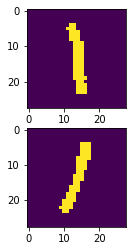

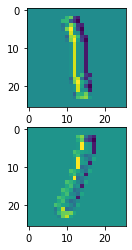

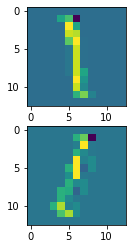

In [43]:
# Conv_output = conv.forward(train_image)
## Seperating 2
i, = np.where(train_labels == 1)
cl1_train = train_images[i,:,:]
##('----------Actual Image--------------')
train21=cl1_train[4,:,:]
train22=cl1_train[5,:,:]
plt.figure()
plt.subplot(2,1,1)
plt.imshow(train21)
# print(train21.shape)
plt.subplot(2,1,2)
plt.imshow(train22)
##('-----------Convolutional Layer Output-----------------------')
Conv_output21 = conv.forward(train21)
Conv_output22 = conv.forward(train22)
plt.figure()
plt.subplot(2,1,1)
plt.imshow(Conv_output21[:,:,4])
plt.subplot(2,1,2)
plt.imshow(Conv_output22[:,:,4])
##('------------Max Pooling Layer Output----------------------')
Pool_output21 = pool.forward(Conv_output21)
Pool_output22 = pool.forward(Conv_output22)
plt.figure()
plt.subplot(2,1,1)
plt.imshow(Pool_output21[:,:,4])
plt.subplot(2,1,2)
plt.imshow(Pool_output22[:,:,4])

## Inferences and Conclusion : State all the key observations and conclusion

CNN can give good results in less no of parameters as compared to FFNN.

CNN is translation invariance.